# UNIVERSIDAD ORT URUGUAY
**SANTIAGO BELZA - 286184**  
**VANESA ALLAN - 247079**

## Exploración de Métodos para Predicción de Tráfico Vehicular: Autorregresivos, Redes Recurrentes, Autoencoders y Modelos Basados en Grafos

### Contexto del Script de Análisis

El siguiente script en Python forma parte del proceso de análisis para la exploración de modelos de predicción de tráfico vehicular en el marco de la investigación realizada. Este script contiene la implementación de un modelo Redes Recurrentes.


### Importación de librerias


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from math import sqrt
import datetime

In [2]:
semilla = 42
np.random.seed(semilla)
tf.random.set_seed(semilla)

### Lectura de los archivos de datos utilizados

In [3]:
from google.colab import drive
drive.mount("/content/drive")
! cp "/content/drive/MyDrive/MasterBigData/Datos_transito.csv" .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from google.colab import drive
drive.mount("/content/drive")
! cp "/content/drive/MyDrive/MasterBigData/data_val_transito.csv" .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_train = pd.read_csv('Datos_transito.csv')
data_val = pd.read_csv('data_val_transito.csv')


### Selección de Datos para la Avenida Av Italia

Se utiliza la siguiente acción para seleccionar las filas correspondientes a la avenida 'Av Italia' con una latitud de -34.886792 y una longitud de -56.129075 en los conjuntos de datos `data_train` y `data_val`:

In [6]:
df = data_train[(data_train['dsc_avenida'] == 'Av Italia')  & (data_train['latitud'] == -34.886792) & (data_train['longitud'] == -56.129075) ]
df_val = data_val[(data_val['dsc_avenida'] == 'Av Italia') & (data_val['latitud'] == -34.886792) & (data_val['longitud'] == -56.129075) ]
df_out = data_train[(data_train['dsc_avenida'] == 'Bv Artigas')  & (data_train['latitud'] == -34.877335) & (data_train['longitud'] == -56.166706) ]

### Transformaciones necesarias en los en cada campo

Antes de utilizar los datos para entrenar modelos, es fundamental realizar ciertas transformaciones en cada campo para prepararlos adecuadamente

In [7]:

df['FechaHora'] = pd.to_datetime(df['FechaHora'])
df_val['FechaHora'] = pd.to_datetime(df_val['FechaHora'])
df_out['FechaHora'] = pd.to_datetime(df_out['FechaHora'])

print(data_train.head())

     latitud   longitud            FechaHora  velocidad_agrupada  \
0 -34.897926 -56.165434  2023-09-01 00:00:00                 0.0   
1 -34.897926 -56.165434  2023-09-01 00:15:00                 0.0   
2 -34.897926 -56.165434  2023-09-01 00:30:00                 0.0   
3 -34.897926 -56.165434  2023-09-01 00:45:00                 0.0   
4 -34.897926 -56.165434  2023-09-01 01:00:00                 0.0   

   volumen_agrupada  dsc_avenida                   key  zona  
0               0.0  18 de Julio  -34.897926-56.165434     2  
1               0.0  18 de Julio  -34.897926-56.165434     2  
2               0.0  18 de Julio  -34.897926-56.165434     2  
3               0.0  18 de Julio  -34.897926-56.165434     2  
4               0.0  18 de Julio  -34.897926-56.165434     2  


<ipython-input-7-a4278147e1db>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FechaHora'] = pd.to_datetime(df['FechaHora'])
<ipython-input-7-a4278147e1db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['FechaHora'] = pd.to_datetime(df_val['FechaHora'])
<ipython-input-7-a4278147e1db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

### Orden de la fecha

In [8]:
df = df.sort_values(by='FechaHora')
df_val = df_val.sort_values(by='FechaHora')
df_out = df_out.sort_values(by='FechaHora')

### Normalización de los dataset

In [9]:
X = df[['volumen_agrupada', 'velocidad_agrupada']].values
y = df['volumen_agrupada'].values

mean_X, std_X = X.mean(axis=0), X.std(axis=0)

X = (X - mean_X) / std_X

y = (y.reshape(-1, 1) - mean_X[0]) / std_X[0]

print(X.shape)
print(y.shape)

(5857, 2)
(5857, 1)


In [10]:
X_val = df_val[['volumen_agrupada', 'velocidad_agrupada']].values
Y_val = df_val['volumen_agrupada'].values

mean_X_val, std_X_val = X_val.mean(axis=0), X_val.std(axis=0)

X_val = (X_val - mean_X_val) / std_X_val

Y_val = (Y_val.reshape(-1, 1) - mean_X_val[0]) / std_X_val[0]

print(X_val.shape)
print(Y_val.shape)

(2881, 2)
(2881, 1)


In [11]:
X_out = df_out[['volumen_agrupada', 'velocidad_agrupada']].values
Y_out = df_out['volumen_agrupada'].values

mean_X_out, std_X_out = X_out.mean(axis=0), X_out.std(axis=0)

X_out = (X_out - mean_X_out) / std_X_out

Y_out = (Y_out.reshape(-1, 1) - mean_X_out[0]) / std_X_out[0]


print(X_out.shape)
print(Y_out.shape)

(5857, 2)
(5857, 1)


### Configuración de la ventana de tiempo para el entrenamiento

In [12]:

n_steps = 4

steps_ahead = 4  # Por ejemplo, para predecir 3 pasos hacia adelante


X_seq, y_seq = [], []

for i in range(len(X) - n_steps - steps_ahead ):
    X_seq.append(X[i:i + n_steps])
    y_seq.append(y[i + n_steps + steps_ahead-1])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

print(X_seq.shape)
print(y_seq.shape)

(5849, 4, 2)
(5849, 1)


In [13]:
X_seq[0:4]

array([[[-0.83271417,  0.3472123 ],
        [-1.07146743,  0.80679716],
        [-1.18089601,  0.59052193],
        [-1.28037654,  0.75272835]],

       [[-1.07146743,  0.80679716],
        [-1.18089601,  0.59052193],
        [-1.28037654,  0.75272835],
        [-1.41467525,  1.21231321]],

       [[-1.18089601,  0.59052193],
        [-1.28037654,  0.75272835],
        [-1.41467525,  1.21231321],
        [-1.37488304,  1.18527881]],

       [[-1.28037654,  0.75272835],
        [-1.41467525,  1.21231321],
        [-1.37488304,  1.18527881],
        [-1.40472719,  0.75272835]]])

In [14]:
y_seq[0]

array([-1.36990901])

### Separación del dataset en train y test

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)


### Configuración de las capas de la red neuronal

In [16]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(n_steps, X_seq.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

### Entrenamiento

In [17]:
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
147/147 [==============================] - 6s 7ms/step - loss: 0.2853
Epoch 2/50
147/147 [==============================] - 1s 7ms/step - loss: 0.1497
Epoch 3/50
147/147 [==============================] - 1s 7ms/step - loss: 0.1218
Epoch 4/50
147/147 [==============================] - 1s 7ms/step - loss: 0.1065
Epoch 5/50
147/147 [==============================] - 1s 7ms/step - loss: 0.0988
Epoch 6/50
147/147 [==============================] - 1s 7ms/step - loss: 0.0929
Epoch 7/50
147/147 [==============================] - 1s 9ms/step - loss: 0.0900
Epoch 8/50
147/147 [==============================] - 3s 19ms/step - loss: 0.0878
Epoch 9/50
147/147 [==============================] - 3s 18ms/step - loss: 0.0844
Epoch 10/50
147/147 [==============================] - 3s 17ms/step - loss: 0.0841
Epoch 11/50
147/147 [==============================] - 2s 12ms/step - loss: 0.0830
Epoch 12/50
147/147 [==============================] - 2s 14ms/step - loss: 0.0811
Epoch 13/50
147/147 

### Predicción

In [18]:
predictions = model.predict(X_test)


37/37 [==============================] - 0s 5ms/step


In [19]:
X_test.shape

(1170, 4, 2)

In [20]:
y_test.shape

(1170, 1)

### Gráfica comparativa

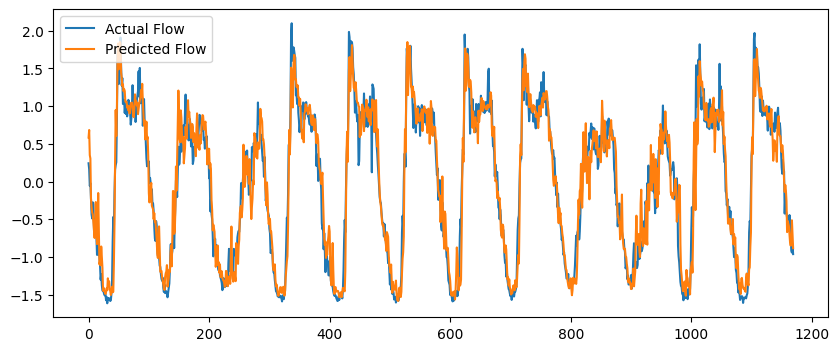

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual Flow')
plt.plot(predictions, label='Predicted Flow')
plt.legend()
plt.show()

### MSE Train

In [22]:

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (MSE): {mse}')


Mean Squared Error (MSE): 0.07076497626433567


In [23]:
X_seq_val, y_seq_val = [], []

for i in range(len(X_val) - n_steps - steps_ahead ):
    X_seq_val.append(X_val[i:i + n_steps])
    y_seq_val.append(Y_val[i + n_steps + steps_ahead -1])

X_seq_val, y_seq_val = np.array(X_seq_val), np.array(y_seq_val)

print(X_seq_val.shape)
print(y_seq_val.shape)

(2873, 4, 2)
(2873, 1)


In [24]:
X_seq_out, y_seq_out = [], []

for i in range(len(X_out) - n_steps - steps_ahead ):
    X_seq_out.append(X_out[i:i + n_steps])
    y_seq_out.append(Y_out[i + n_steps + steps_ahead -1])

X_seq_out, y_seq_out = np.array(X_seq_out), np.array(y_seq_out)

print(X_seq_out.shape)
print(y_seq_out.shape)

(5849, 4, 2)
(5849, 1)


### Predicción en Validación


In [25]:
predictions_val = model.predict(X_seq_val)

Y_val = y_seq_val
predictions_val =  predictions_val



90/90 [==============================] - 0s 5ms/step


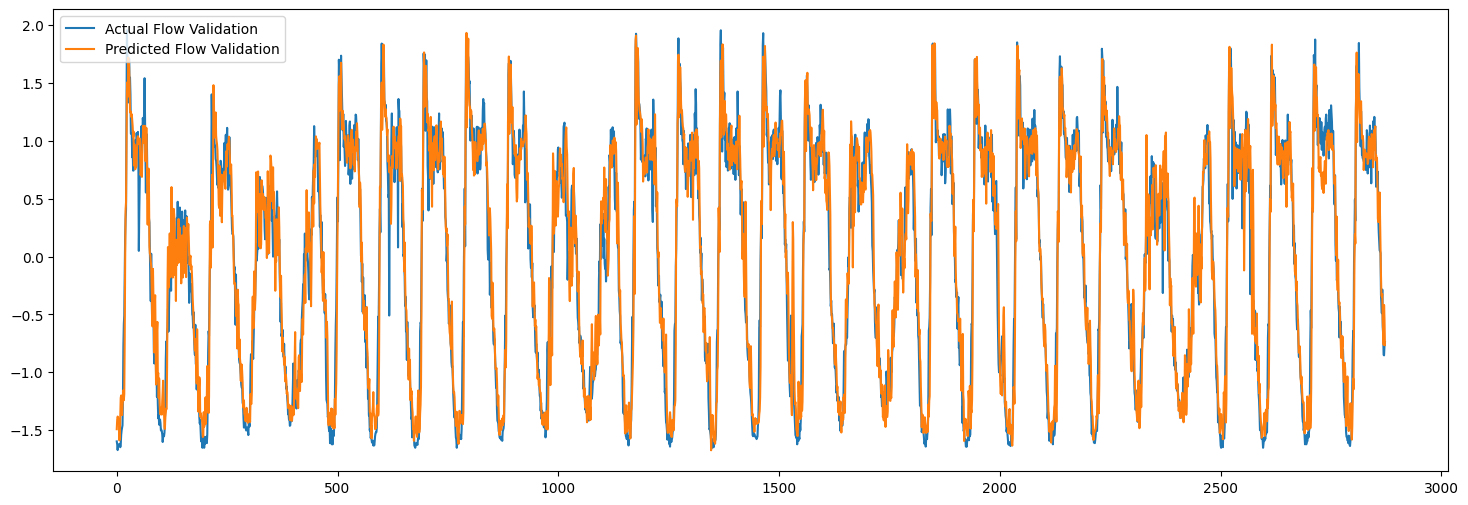

MSE for validation data: 0.0744443469666297


In [26]:
plt.figure(figsize=(18, 6))
plt.plot(Y_val, label='Actual Flow Validation')
plt.plot(predictions_val, label='Predicted Flow Validation')
plt.legend()
plt.show()


mse= mean_squared_error(Y_val, predictions_val)
print(f'MSE for validation data: {mse}')


### Predicción en otra calle

In [27]:
predictions_out = model.predict(X_seq_out)

Y_out = y_seq_out
predictions_out =  predictions_out

183/183 [==============================] - 1s 5ms/step


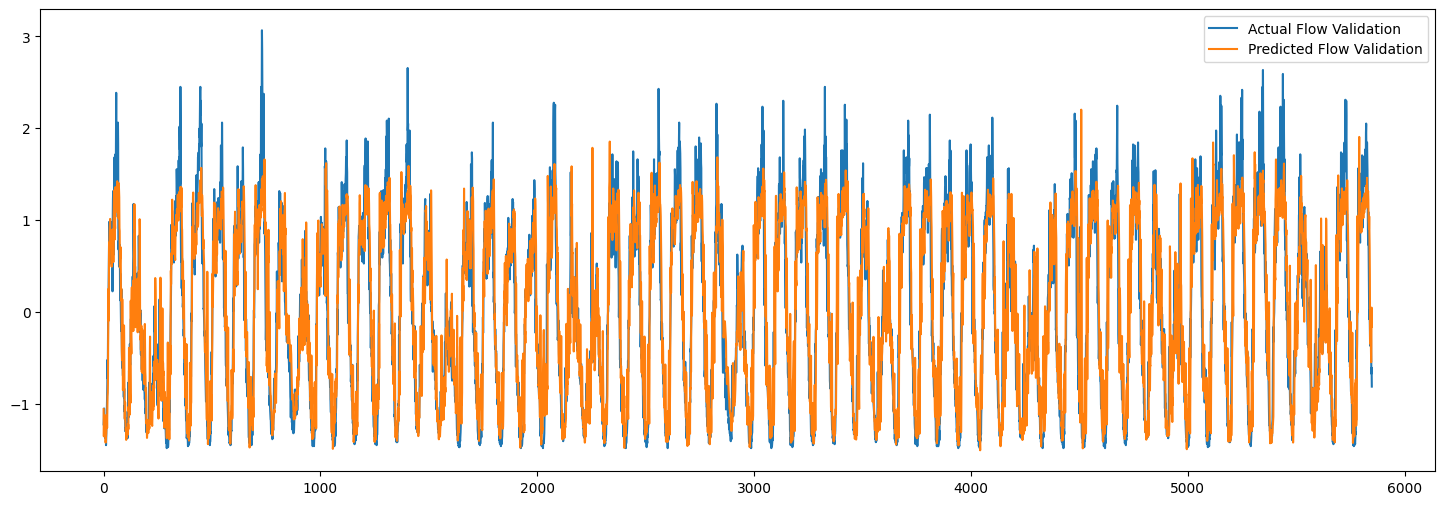

MSE for out data: 0.19348328047890007


In [28]:
plt.figure(figsize=(18, 6))
plt.plot(Y_out, label='Actual Flow Validation')
plt.plot(predictions_out, label='Predicted Flow Validation')
plt.legend()
plt.show()


mse= mean_squared_error(Y_out, predictions_out)
print(f'MSE for out data: {mse}')
